Per un umano classificare il contenuto di un'immagine con un dataset piccolo è una cosa fattibile ma per un computer ? Il numero di samples è un grosso problema per le reti neurali. E' in questo caso che si parla di "few-shot learning". Esso si distingue dal supervised learning standard per il suo obiettivo, ovvero il learn to learn: si cerca di riconoscere la somiglianza e la differenza tra immagini e non di riconoscere il contesto preciso delle immagini del dataset e generalizzarlo per le immagini del test set.
Il few-shot learning è un tipo di meta learning cioè una branca dell’apprendimento automatico che si concentra sull’uso di tecniche di apprendimento per migliorare l’efficienza di quello automatico (learn to learn).
Se si parla di performance del few-shot learning, troviamo che l'accuracy della predizione dipende dal numero di classi e dal numero di samples per classi, nello specifico all'aumentare del numero di classi l'accuracy diminuisce, e inversamente essa aumenta all'aumentare dei samples.

#**Imports delle librerie**


In [1]:
#import vari
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image_dataset_from_directory
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Concatenate, Add, Average, Activation, Lambda, Reshape, GlobalAveragePooling2D
from keras.api._v2.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

#Variabili
img_height = 256
img_width = 256
batch_size = 128
class_names = ['A_Silent_Voice', 'Attack_on_Titans', 'Death_Note', 'Demon_Slayer', 'Dragon_Ball', 'Fruits_Basket', 'Full_Metal_Alchemist_Brotherhood',
               'Gintama', 'Hunter_X_Hunter', 'Jujutsu_Kaisen', 'My_Hero_Academia', 'Naruto', 'One_Punch_Man', 'One_piece', 'Re_ZERO', 'Steins;Gate']
print(tf.version)


<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.10/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [ ]:
#SERVE PER MIGLIORARE LA VELOCITA DI ALLENAMENTO, CREA UNO WARNING PER INCOMPATIBILITA' DI VERSIONI TENSORFLOW
'''from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)'''

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Caricamento del dataset per il classificatore:
###**Non eseguire se si vuole allenare esclusivamente la rete siamese**
###il caricamento delle immagini per il classificatore è stato impiegato nel file KNN-classifier. Per completezza seguono vari metodi possibili da utilizzare per il caricamento delle immagini singolarmente in modo da testarne il funzionamento


##Caricamento dataset classificatore con image_dataset_from_directory:




In [3]:
#CARICARE DATASET image_dataset_from_directory
#https://www.youtube.com/watch?v=q7ZuZ8ZOErE


#IMPORT DATA E LABELS
#1) Primo metodo:  image_dataset_from_directory
ds_train = image_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames',
    labels = 'inferred',
    label_mode = "int",
    class_names = class_names, #da togliere per scalabilità
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size =  (img_height, img_width), #reshape if not in this size
    shuffle =True,
    seed =123,
    validation_split = 0.1,
    subset = "training",
)

ds_validation = image_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames',
    labels = 'inferred',
    label_mode = "int",
    class_names = class_names,
    color_mode = 'rgb',
    image_size =  (img_height, img_width), #reshape if not in this size
    shuffle =True,
    seed =123,
    validation_split = 0.1,
    subset = "validation",
)

ds_test = image_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames_test',
    labels = 'inferred',
    label_mode = "int",
    class_names = class_names,
    color_mode = 'rgb',
    image_size =  (img_height, img_width), #reshape if not in this size
    shuffle =True,
    seed =123
)

# POSSIBILE FUNZIONE DI AUGMENTATION:
def augment(x,y):
  image = tf.image.random_brightness(x, max_delta =0.05)
  #inserire metodi di aumento immagini (scale, rotazione ecc) : non implementata perchè non sarà necessario riconoscere frame ribaltati
  return image,y
#ds_train = ds_train.map(augment)

Found 3280 files belonging to 16 classes.
Using 2952 files for training.
Found 3280 files belonging to 16 classes.
Using 328 files for validation.
Found 714 files belonging to 16 classes.


In [ ]:
print(ds_train)
ds_train_cardinality =0
labels_train = []
for i, (images,labels) in enumerate(ds_train.as_numpy_iterator()):
  for j in range(len(images)):
    labels_train.append(labels[j])
    ds_train_cardinality = ds_train_cardinality+1
np.save("/content/drive/MyDrive/Colab Notebooks/PROGETTO/labels_train.npy",labels_train)
print("DS_TRAIN cardinality: ",ds_train_cardinality, "labels_train cardinality: ", len(labels_train))


<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
DS_TRAIN cardinality:  2952 labels_train cardinality:  2952


In [ ]:
print(ds_validation)
ds_validation_cardinality =0
labels_validation = []
for i, (images,labels) in enumerate(ds_validation.as_numpy_iterator()):
  for j in range(len(images)):
    labels_validation.append(labels[j])
    ds_validation_cardinality = ds_validation_cardinality+1
np.save("/content/drive/MyDrive/Colab Notebooks/PROGETTO/labels_validation.npy",labels_validation)
print("DS_VAL cardinality: ",ds_validation_cardinality, "labels_validation cardinality: ", len(labels_validation))

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
DS_VAL cardinality:  328 labels_validation cardinality:  328


In [4]:
print(ds_test)
ds_test_cardinality =0
labels_test = []
for i, (images,labels) in enumerate(ds_test.as_numpy_iterator()):
  for j in range(len(images)):
    labels_test.append(labels[j])
    ds_test_cardinality = ds_test_cardinality+1
np.save("/content/drive/MyDrive/Colab Notebooks/PROGETTO/labels_test.npy",labels_test)
print("DS_TEST cardinality: ",ds_test_cardinality, "labels_test cardinality: ", len(labels_test))

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
DS_TEST cardinality:  714 labels_test cardinality:  714


In [ ]:
num_batches = ds_train.cardinality().numpy() #6
num_samples = ds_train_cardinality

print(num_batches)

##Visualizzare il dataset classificatore

In [ ]:
##SHOW DATA
class_names = class_names
plt.figure(figsize=(10, 10))

for images, labels in ds_train.take(1): #prendi 1 solo batch, default = 128
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

##Conversione ds_train a numpy array
###**Alto consumo di RAM : non usare**

In [ ]:
#CONVERSIONE TF.DATA.DATASET A NUMPAY ARRAY
#metodo lab3
def dataset_to_numpy(data, img_shape, num_samples=0):
  if num_samples == 0:
    num_batches = data.cardinality().numpy() #6
    num_samples = ds_train_cardinality
    print(num_samples)
  it = data.as_numpy_iterator() #ritorna obj che implements Iterator, ossia l'intero BATCH (32) (ne ridefinisce i metodi next() , hasNext())
  train_X = np.zeros((num_samples, img_height, img_width, 3))
  train_y = np.zeros(num_samples)
  samples=0
  for i, (images,labels) in tqdm(enumerate(it), total=num_batches): #ogni batch di 32 img
    for j in range(len(images)):
      #print(samples)
      curr = np.asarray(images[j])
      #np.concatenate((train_X, curr))
      train_X[samples,:,:,:] = curr
      train_y[samples] = labels[j]
      samples = samples+1
  return train_X, train_y
#ds_train.shuffle(ds_train.cardinality())

#print(ds_train)
#print(X_train)

In [ ]:
X_train, y_train = dataset_to_numpy(ds_train, (img_height, img_width), )
#print("SHAPE: ", train_X.shape)
#print("SHAPE: ", train_y.shape)
#print("METODO LAB3 : " , train_X)
#print("LABELS: ", train_y)

283


100%|██████████| 9/9 [00:02<00:00,  3.02it/s]


#

#**Dataset della rete siamese**



##Caricamento Dataset per siamese da file csv (paths)
###Per allenare la rete siamese dovremmo utilizzare un dataset di immagini etichettate come simili (0) o non simili (1).

####training example x = coppia di img
####training label y = etichetta di somiglianza 0/1


In [ ]:
from matplotlib.cbook import print_cycles
import pandas as pd
csv_path = '/content/drive/MyDrive/Colab Notebooks/PROGETTO/siamese_ds_balanced.csv'

# Read the CSV file into a pandas DataFrame
data = pd.read_csv(csv_path)

file_pathsA = data['ImageA'].values
file_pathsB = data['ImageB'].values
pair_paths = (file_pathsA, file_pathsB)
labels = data['Label'].values

ds = tf.data.Dataset.from_tensor_slices(((file_pathsA, file_pathsB), labels))
ds= ds.shuffle(buffer_size=1400000, seed=123)

count=0
for i in ds.as_numpy_iterator():
  print(i)
  count+=1
  if count == 10:
    break

'''
#DEBUG DS DATASET DEI PATHS
image = tf.io.read_file("/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Attack_on_Titans/Attack_on_Titans_4.jpg")
image = tf.io.read_file(pair[1][4])
print(pair[1][4])
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.convert_image_dtype(image, tf.float32)
plt.imshow(image.numpy().astype('float32'))
'''

((b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/A_Silent_Voice/A_Silent_Voice_80.jpg', b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Death_Note/Death_Note_835.jpg'), 1)
((b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Demon_Slayer/Demon_Slayer_220.jpg', b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Demon_Slayer/Demon_Slayer_507.jpg'), 0)
((b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/A_Silent_Voice/A_Silent_Voice_198.jpg', b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/A_Silent_Voice/A_Silent_Voice_277.jpg'), 0)
((b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Full_Metal_Alchemist_Brotherhood/Full_Metal_Alchemist_Brotherhood_205.jpg', b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Jujutsu_Kaisen/Jujutsu_Kaisen_414.jpg'), 1)
((b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Naruto/Naruto_453.jpg', b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Naruto/Naruto_310.jpg'), 0)
((b

'\n#DEBUG DS DATASET DEI PATHS\nimage = tf.io.read_file("/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Attack_on_Titans/Attack_on_Titans_4.jpg")\nimage = tf.io.read_file(pair[1][4])\nprint(pair[1][4])\nimage = tf.image.decode_jpeg(image, channels=3)\nimage = tf.image.convert_image_dtype(image, tf.float32)\nplt.imshow(image.numpy().astype(\'float32\'))\n'

In [ ]:
#IMPORTANTE PER FIXARE PROBLEMI DELLA SHUFFLE CLASSICA : ripetere almeno 2 volte per essere sicuri di mischiare bene il dataset per training
ds= ds.shuffle(buffer_size=1400000, seed=123)
count=0
for i in ds.as_numpy_iterator():
  print(i)
  count+=1
  if count == 10:
    break

((b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Jujutsu_Kaisen/Jujutsu_Kaisen_246.jpg', b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Jujutsu_Kaisen/Jujutsu_Kaisen_648.jpg'), 0)
((b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Gintama/Gintama_492.jpg', b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Steins;Gate/Steins;Gate_113.jpg'), 1)
((b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Death_Note/Death_Note_763.jpg', b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/One_piece/One_piece_2_168.jpg'), 1)
((b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Jujutsu_Kaisen/Jujutsu_Kaisen_463.jpg', b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Jujutsu_Kaisen/Jujutsu_Kaisen_510.jpg'), 0)
((b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Death_Note/Death_Note_348.jpg', b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Steins;Gate/Steins;Gate_66.jpg'), 1)
((b'/content/drive/MyDrive/Colab Notebook

In [ ]:
#ALTERNATIVA PER UN ALLENAMENTO PIU' RAPIDO: USO DI UN DATASET PIU PICCOLO
import random
count_rows = ds.cardinality().numpy()
ds_reduced = ds.take(count_rows//2)
print(ds_reduced.cardinality().numpy())

In [ ]:
def get_images(inputs,label) :
  img1 = tf.io.read_file(inputs[0])
  img2 = tf.io.read_file(inputs[1])
  return (img1,img2) , label

def process_image(inputs, label):
  img1 = tf.image.decode_jpeg(inputs[0], channels=3)
  img2 = tf.image.decode_jpeg(inputs[1], channels=3)
  img1 = tf.image.convert_image_dtype(img1, tf.float32)
  img2 = tf.image.convert_image_dtype(img2, tf.float32)
  img1 = tf.image.resize(img1, [img_height, img_width])
  img2 = tf.image.resize(img2, [img_height, img_width])
  return (img1, img2), label

In [ ]:
#FUNZIONE PER MOSTRARE LE IMMAGINI DEL DATASET SIAMESE
def show_image_pair_batch(image_batch, label_batch):
    fig, axes = plt.subplots(5, 2, figsize=(10,10) )
    for i in range(5):
        axes[i, 0].imshow(image_batch[0][i].numpy().astype("float32"))
        axes[i, 0].set_title(f'Image 1, Label: {label_batch[i].numpy()}')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(image_batch[1][i].numpy().astype("float32"))
        axes[i, 1].set_title(f'Image 2, label: {label_batch[i].numpy()}')
        axes[i, 1].axis('off')
    #plt.tight_layout()
    plt.show()

In [ ]:
#PROCESSAMENTO DELLE IMMAGINI DELLA SIAMESE
AUTOTUNE = tf.data.experimental.AUTOTUNE
X1 = X2 = X3 =  AUTOTUNE
num_elements = ds.cardinality().numpy()
# Calculate the number of elements to take (10% of the total)
num_take = int(num_elements * 0.1)

for i in ds.take(2):
  (img1, img2), label = i
  print(img1, img2)

# Take 10% of the data
validation_sm = ds.take(num_take)
validation_sm = validation_sm.map(get_images,num_parallel_calls=X1)
validation_sm = validation_sm.map(process_image, num_parallel_calls=X2)
validation_sm = validation_sm.batch(batch_size= batch_size)
validation_sm = validation_sm.prefetch(buffer_size=X3)

AUTOTUNE2 = tf.data.experimental.AUTOTUNE
Y1 = Y2 = Y3  = AUTOTUNE2
train_sm = ds.skip(num_take)
#train_sm = train_sm.shuffle(200000,123) #AGGIUNTO PER SICUREZZA
train_sm = train_sm.map(get_images,num_parallel_calls=Y1)
train_sm = train_sm.map(process_image,num_parallel_calls=Y2)
train_sm = train_sm.batch(batch_size=batch_size)
train_sm = train_sm.prefetch(buffer_size=Y3)



tf.Tensor(b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/A_Silent_Voice/A_Silent_Voice_101.jpg', shape=(), dtype=string) tf.Tensor(b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Re_ZERO/Re_ZERO_30.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Gintama/Gintama_85.jpg', shape=(), dtype=string) tf.Tensor(b'/content/drive/MyDrive/Colab Notebooks/PROGETTO/_frames/Jujutsu_Kaisen/Jujutsu_Kaisen_322.jpg', shape=(), dtype=string)


In [ ]:
#PROCESSAMENTO DELLE IMMAGINI DELLA SIAMESE, DATASET RIDOTTO
#NON RANNARE SE SI USA IL DATASET COMPLETO
AUTOTUNE = tf.data.experimental.AUTOTUNE
X1 = X2 = X3 =  AUTOTUNE
num_elements = ds_reduced.cardinality().numpy()
# Calculate the number of elements to take (10% of the total)
num_take = int(num_elements * 0.1)

for i in ds_reduced.take(2):
  (img1, img2), label = i
  print(img1, img2)

# Take 10% of the data
validation_sm = ds_reduced.take(num_take)
validation_sm = validation_sm.map(get_images,num_parallel_calls=X1)
validation_sm = validation_sm.map(process_image, num_parallel_calls=X2)
validation_sm = validation_sm.batch(batch_size= batch_size)
validation_sm = validation_sm.prefetch(buffer_size=X3)

AUTOTUNE2 = tf.data.experimental.AUTOTUNE
Y1 = Y2 = Y3  = AUTOTUNE2
train_sm = ds_reduced.skip(num_take)
#train_sm = train_sm.shuffle(200000,123) #AGGIUNTO PER SICUREZZA
train_sm = train_sm.map(get_images,num_parallel_calls=Y1)
train_sm = train_sm.map(process_image,num_parallel_calls=Y2)
train_sm = train_sm.batch(batch_size=batch_size)
train_sm = train_sm.prefetch(buffer_size=Y3)

(128, 256, 256, 3) (128, 256, 256, 3) label:  <dtype: 'int64'>
<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


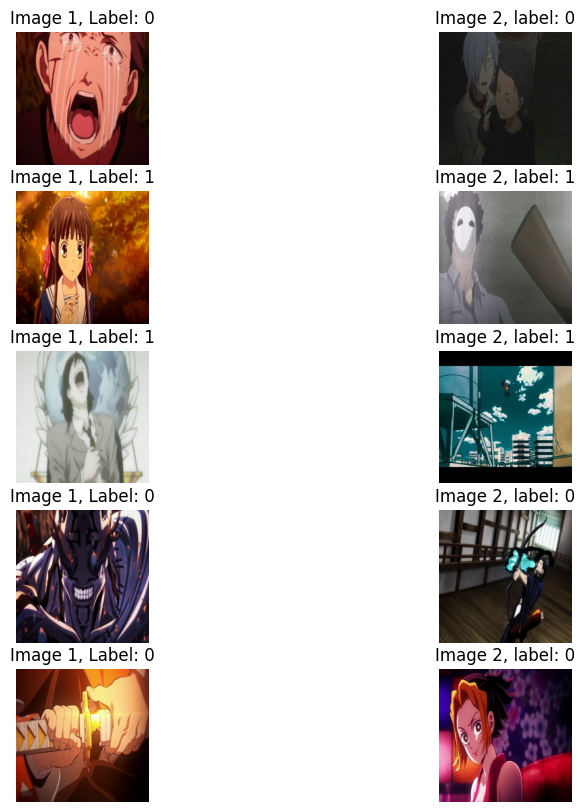

In [ ]:
#VISUALIZZARE IL DATASET SIAMESE
for i in train_sm.take(1):
  (img1, img2), label = i
  print(img1.shape, img2.shape, 'label: ', label.dtype)
print(train_sm)

for pair, label in train_sm.take(1): #prendi 1 solo batch, default = 32
  show_image_pair_batch(pair, label)

In [ ]:
#VARIE CARDINALITA' DEL DATASET SIAMESE
data_card = ds.cardinality().numpy()
sm_cardinality = tf.data.experimental.cardinality(train_sm).numpy() #number of batches
val_card = validation_sm.cardinality().numpy()
#num_elements = tf.data.experimental.cardinality(ds).numpy()
print(f"TOTAL:-> ", data_card )
print(f"TRAIN: Number of batches, to multiply for {batch_size} -> ", sm_cardinality) #1.210.496 train
print(f"VALID: Number of batches, to multiply for {batch_size} -> ", val_card)

TOTAL:->  1344976
TRAIN: Number of batches, to multiply for 128 ->  9457
VALID: Number of batches, to multiply for 128 ->  1051


#**Architettura Siamese-VGG16**

###Come backbone si cerca un'archittetura molto popolare utilizzata per la classificazione delle immagini.
###In termini di feature extraction, ResNet ha dimostrato di essere migliore di VGG. Tuttavia la scelta dipende dal task specifico e da diverse esigenze quindi si potrebbero provare entrambi.

In [ ]:
#ALTERNATIVA BACKBONE VGG-16
def createBaseModel(input):
  VGG16_noTop = tf.keras.applications.vgg16.VGG16(
      include_top=False,
      weights='imagenet',
      input_tensor=None,
      input_shape=(img_height, img_width, 3)
  )
  x = VGG16_noTop(input)
  x = GlobalAveragePooling2D()(x)
  #ottieni insert yourfavourite poolingp_a= GlobalAveragePooling2D()(p_a= GlobalAveragePooling2D()(
  x= Dense(512)(x)
  return Model(input, x, name="Base_model_VGG16")

In [ ]:
import keras
#define custom layer with distance function
def squared_euclidean(vecs):
  # split input
  x,y = vecs
  #EUCLIDEAN DISTANCE
  return tf.sqrt(tf.reduce_sum(tf.square(x-y), axis=1, keepdims=True))

def euclidean_distance_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

In [ ]:
#rete siamese params
input_shape = (img_height, img_width, 3)
imgL = Input(input_shape)
imgR = Input(input_shape)

In [ ]:
#COSTRUZIONE RETE SIAMESE VGG16
base_model = createBaseModel(imgL)

features_vectorL = base_model(imgL)
features_vectorR = base_model(imgR)

#AGGIUNTA : L2 normalization
l2 = Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) #provo con dei vettori in ingresso;
l2_L = l2(features_vectorL)
l2_R = l2(features_vectorR)

#output_dist = Lambda(squared_euclidean)([features_vectorL, features_vectorR])
output_dist = Lambda(squared_euclidean, output_shape= euclidean_distance_output_shape)([l2_L, l2_R])
print(features_vectorL, "\n", features_vectorR, "\nLa distanza tra i due vettori è : ",output_dist )

58889256/58889256 [==============================] - 0s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='Base_model_VGG16/dense_2/BiasAdd:0', description="created by layer 'Base_model_VGG16'") 
 KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='Base_model_VGG16/dense_2/BiasAdd:0', description="created by layer 'Base_model_VGG16'") 
La distanza tra i due vettori è :  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='lambda_1/Sqrt:0', description="created by layer 'lambda_1'")


In [ ]:
#VGG-16
#now put everything together
#define the model
#now define the lambda layer which takes as input the two vectors
siamese = Model([imgL, imgR], output_dist)
#note how the number of params of the siamese and base model is the same!
siamese.summary()
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Base_model_VGG16 (Function  (None, 128)                  1487891   ['input_4[0][0]',             
 al)                                                      2          'input_5[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 128)                  0         ['Base_model_VGG16[0][0]',

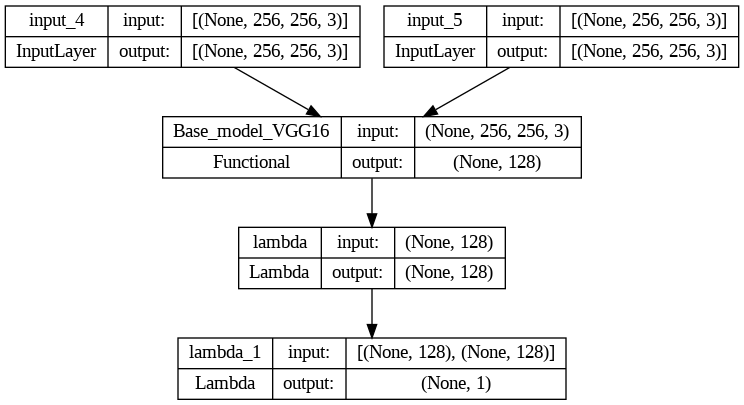

In [ ]:
tf.keras.utils.plot_model(siamese, "siamese.png",show_shapes=True)

#**Architettura Siamese-ResNet50**

###Come backbone si cerca un'archittetura molto popolare utilizzata per la classificazione delle immagini.
###In termini di feature extraction, ResNet ha dimostrato di essere migliore di VGG. Tuttavia la scelta dipende dal task specifico e da diverse esigenze quindi si potrebbero provare entrambi.

In [ ]:
#BACKBONE RESNET50
def createBaseModel_ResNet(input):
  ResNet_noTop = tf.keras.applications.resnet50.ResNet50(
      include_top=False,
      weights='imagenet',
      input_tensor=None,
      input_shape=(img_height, img_width, 3)
  )
  x = ResNet_noTop(input, training=False)
  x = GlobalAveragePooling2D()(x)
  # insert yourfavourite poolingp_a= GlobalAveragePooling2D()(p_a= GlobalAveragePooling2D()()
  x = Dense(512)(x) #MANTENERE canali in uscita da RESNET 2048 non dovrebbe rallentare, ma rallenta di moltissimo
  return Model(input, x, name ="Base_model_RESNET")

In [ ]:
import keras
#define custom layer with distance function
def squared_euclidean(vecs):
  # split input
  x,y = vecs
  #EUCLIDEAN DISTANCE
  return tf.sqrt(tf.reduce_sum(tf.square(x-y), axis=1, keepdims=True))

def euclidean_distance_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

In [ ]:
#rete siamese params
input_shape = (img_height, img_width, 3)
imgL = Input(input_shape)
imgR = Input(input_shape)

In [ ]:
#COSTRUZIONE RETE SIAMESE RRN50
#RICARICA IL MODELLO NON ALLENATO PER LA PRIMA VOLTA
from os import name
#rete siamese using RESNET
base_model_RRN = createBaseModel_ResNet(imgL)
features_vectorL_RRN = base_model_RRN(imgL)
features_vectorR_RRN = base_model_RRN(imgR)

#AGGIUNTA : L2 normalization
#L2 normalization (da slides)
l2 = Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name= 'Normalizzatore_Features') #provo con dei vettori in ingresso
l2_L = l2(features_vectorL_RRN)
l2_R = l2(features_vectorR_RRN)

output_dist_RRN = Lambda(squared_euclidean, output_shape= euclidean_distance_output_shape, name ='Distanza_euclidea')([l2_L, l2_R])
print(features_vectorL_RRN, "\n", features_vectorR_RRN, "\nLa distanza tra i due vettori è : ",output_dist_RRN )

KerasTensor(type_spec=TensorSpec(shape=(None, 512), dtype=tf.float32, name=None), name='Base_model_RESNET/dense_3/BiasAdd:0', description="created by layer 'Base_model_RESNET'") 
 KerasTensor(type_spec=TensorSpec(shape=(None, 512), dtype=tf.float32, name=None), name='Base_model_RESNET/dense_3/BiasAdd:0', description="created by layer 'Base_model_RESNET'") 
La distanza tra i due vettori è :  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='Distanza_euclidea/Sqrt:0', description="created by layer 'Distanza_euclidea'")


In [ ]:
siamese_RRN = Model([imgL, imgR], output_dist_RRN)
#note how the number of params of the siamese and base model is the same!
siamese_RRN.summary()
#siamese_RRN.save("/content/drive/MyDrive/Colab Notebooks/PROGETTO/siamese_RRN_model.keras")
base_model_RRN.layers[1].summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Base_model_RESNET (Functio  (None, 512)                  2463680   ['input_7[0][0]',             
 nal)                                                     0          'input_8[0][0]']             
                                                                                                  
 Normalizzatore_Features (L  (None, 512)                  0         ['Base_model_RESNET[0][0

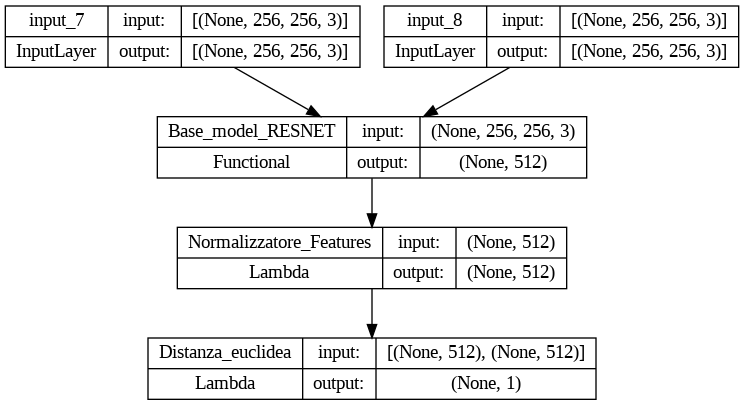

In [ ]:
tf.keras.utils.plot_model(siamese_RRN, "siamese.png",show_shapes=True)

#Funzioni necessarie per gli allenamenti: Warmup e fine tuning

In [6]:
import pandas
def plot_losses(history):
  pandas.DataFrame(history.history).plot(figsize=(10,8))
  plt.grid(True)
  plt.gca().set_ylim(0,1)
  plt.show()

In [7]:
import pandas
def plot_losses_csv(history):
  pandas.DataFrame(history).plot(figsize=(10,8))
  plt.grid(True)
  plt.gca().set_ylim(0,1)
  plt.show()

In [8]:
#Contrastive Loss : mette i features vector in spazio delle feature :
#più lontani piu le immagini diverse, piu vicine piu simili: MARGIN indica la soglia (+ piccolo , piu è facile considerarle dissimili)
def contrastive_loss(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels
        y_pred: List of predictions of same length as of y_true

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, dtype=tf.float32)
    margin = 1
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square) #METTENDO CAST float (y_true) e a (y_pred) funziona

#**Training Rete Siamese-VGG16: Compilazione e fit**
##**1) Warm-Up**

##Freeze top layers e compile

In [ ]:
#FREEZE VGG-16
base_model.layers[1].trainable = False
base_model.summary()
siamese.summary()

In [ ]:
#VGG-16 : LR FISSA
lr = 0.01
siamese.compile(loss= contrastive_loss,
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

In [ ]:
#VGG: CALLBACKS
from keras.api._v2.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=20)

batch_size = 128 #provare a 128
step_per_epochs = 256 #iterazioni per epoca : 256 batches da 128 batch size
validation_steps = 256

#checkpoint: usa il path più adatto ai tuoi scopi per salvare il modello ogni tot epoche
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_LRadaptive/siamese_RRN_warmup_weights.{epoch:02d}-{loss:.2f}.hdf5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    save_best_only = True,
    verbose = 1,
    mode='auto',
    save_freq = step_per_epochs, #per i precedenti esperimenti warmup era = batch_size 128
    include_optimizer=True)

#callback per salvare i risultati delle epoche
history_log =  '/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_LRadaptive/history_RRN_warmup.csv'
CSVlogger_warmup = tf.keras.callbacks.CSVLogger(
    history_log , separator=',', append=True
)

##Variabili di allenamento warmup e Training warmup

In [ ]:
#-------------------ALLENAMENTO INIZIALE-------------------
total_epochs = 37 #37 necessarie con batch size 128, step per epoch 256
history_siamese_VGG = siamese.fit(
    x=train_sm,
    steps_per_epoch = step_per_epochs,
    initial_epoch =0,
    epochs=total_epochs,
    validation_data= validation_sm,
    validation_steps = validation_steps,
    batch_size=batch_size,
    callbacks=[es, model_checkpoint_callback, CSVlogger_warmup])
siamese.save("/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_LRadaptive/siamese_VGG_warmup.h5")

In [ ]:
#RIPRENDERE L'ALLENAMENETO MODIFICANDO INITIAL EPOCH SALVATA DALLA CHECKPOINT
checkpoint = '' #inserire checkpoit
siamese = keras.models.load_model(checkpoint, custom_objects={'contrastive_loss': contrastive_loss})

In [ ]:
siamese.compile(loss= contrastive_loss, metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate= lr)) #puoi aggiungere step per execution
siamese.summary()

In [ ]:
initial_epoch = 30 #MODIFICARE, parte dalla 11 se usi 10
total_epochs = 37
step_per_epochs = 256 #iterazioni per epoca : 100 batches da 128 campioni
validation_steps = 256
history_siamese_VGG = siamese.fit(
    x=train_sm,
    steps_per_epoch = step_per_epochs,
    initial_epoch = initial_epoch,
    epochs=total_epochs,
    validation_data= validation_sm,
    validation_steps = validation_steps,
    batch_size=batch_size,
    callbacks=[es, model_checkpoint_callback, CSVlogger_warmup])
siamese.save("/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_LRadaptive/siamese_VGG_warmup.h5")

In [ ]:
#CARICAMENTO HISTORY CSV
import pandas as pd
history_csv_path =  '/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_LRadaptive/history_VGG_warmup.csv'
history_warmup = pd.read_csv(history_csv_path)

In [ ]:
plot_losses_csv(history_warmup)

In [ ]:
#ALTERNATIVA: SALVATAGGIO HISTORY COME JSON PER COMODITA'
import json
import pandas as pd
#history_warmup_list.append(history_siamese_RRN)
history_warmup_list=[history_siamese_VGG]

json_string = json.dumps(history_siamese_VGG.history)
json_string_list=''
with open("/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_LR0,00006(-0,00001)/history_siamese_VGG_warmup.json", "w") as f:
    f.write(json_string)

for history in history_warmup_list:
  json_string_list += json.dumps(history.history)
  with open("/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_LR0,00006(-0,00001)/history_warmup_list.json", "w") as f:
      f.write(json_string_list)

#**Training Rete Siamese-VGG16: Compilazione + fit**
##**2) Fine-tuning**
###sfruttare le celle proposte nel fine tuning operato con la RRN, modificando le variabili


##Unfreeze dei layers VGG-16

In [ ]:
#UNFREEZE VGG-16 IN BASE_MODEL
base_model.layers[1].trainable = True
siamese.summary()

In [ ]:
lr = 0.00006
siamese.compile(loss= contrastive_loss,
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'])

In [ ]:
history_siamese_ft = siamese.fit(x=train_sm,
          validation_data= validation_sm,
          epochs=1,
          batch_size=batch_size,
          callbacks=[es])


#**Training Rete Siamese-ResNet50: Compilazione e fit**
##**1) Warm-Up**

##Freeze top layers e compile

In [ ]:
#FREEZE RRN
base_model_RRN.layers[1].trainable = False
base_model_RRN.summary()
siamese_RRN.summary()

In [ ]:
#RRN : VERSIONE 1 = UTILIZZO LEARNING RATE FISSA
lr = 0.00001
siamese_RRN.compile(loss= contrastive_loss, metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr)) #puoi aggiungere step per execution

In [ ]:
#RRN: VERSIONE 2 = UTILIZZO LEARNING RATE VARIABILE
#PARAMETRI ALLENAMENTO FINE TUNING
lr = 0.0001 #lr iniziale

#VARIAZIONE 1 : LEARNING RATE VARIABILE FISSA
'''la learning rate decade ogni 8 epoche a batch size di 128: passare lo schedule direttamente alla compile LR'''
learning_rate_schedule = ExponentialDecay(initial_learning_rate=lr, decay_steps= 2048, decay_rate=0.10,  staircase=True)

In [ ]:
siamese_RRN.compile(loss= contrastive_loss, metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule))

In [ ]:
#RRN : LEARNING RATE VARIABILE E CALLBACKS
from keras.api._v2.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=20)

#VARIAZIONE 2 : LEARNING RATE VARIABILE CON CALLBACK
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=0.000006
)

batch_size = 128 #provare a 128
step_per_epochs = 256 #iterazioni per epoca : 256 batches da 128 batch size
validation_steps = 256

#checkpoint: usa il path più adatto ai tuoi scopi per salvare il modello ogni tot epoche
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_BatchNorm_LRadaptive/siamese_RRN_warmup_weights.{epoch:02d}-{loss:.2f}.hdf5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    save_best_only = True,
    verbose = 1,
    mode='auto',
    save_freq = step_per_epochs, #per i precedenti esperimenti warmup era = batch_size 128
    include_optimizer=True)

#callback per salvare i risultati delle epoche
history_log =  '/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_BatchNorm_LRadaptive/history_RRN_warmup.csv'
CSVlogger_warmup = tf.keras.callbacks.CSVLogger(
    history_log , separator=',', append=True
)

##Variabili di allenamento warmup e Training warmup

In [ ]:
#-------------------ALLENAMENTO INIZIALE-------------------
total_epochs = 37 #37 necessarie con batch size 128, step per epoch 256
history_siamese_RRN = siamese_RRN.fit(
    x=train_sm,
    steps_per_epoch = step_per_epochs,
    initial_epoch =0,
    epochs=total_epochs,
    validation_data= validation_sm,
    validation_steps = validation_steps,
    batch_size=batch_size,
    callbacks=[es, model_checkpoint_callback, lr_callback, CSVlogger_warmup])
siamese_RRN.save("/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_BatchNorm_LRadaptive/siamese_RRN_warmup.h5")

In [ ]:
#RIPRENDERE L'ALLENAMENETO MODIFICANDO INITIAL EPOCH SALVATA DALLA CHECKPOINT
checkpoint = '/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_BatchNorm_LRadaptive/siamese_RRN_warmup_weights.30-0.24.hdf5'
siamese_RRN = keras.models.load_model(checkpoint, custom_objects={'contrastive_loss': contrastive_loss})

In [ ]:
siamese_RRN.compile(loss= contrastive_loss, metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate= learning_rate_schedule)) #puoi aggiungere step per execution
siamese_RRN.summary()

In [ ]:
#RIPRESA ALLENAMENTO DA CHECKPOINT
initial_epoch = 30 #MODIFICARE, parte dalla 11 se usi 10
total_epochs = 37
step_per_epochs = 256 #iterazioni per epoca : 256 batches da 128 campioni l'uno
validation_steps = 256
history_siamese_RRN = siamese_RRN.fit(
    x=train_sm,
    steps_per_epoch = step_per_epochs,
    initial_epoch = initial_epoch,
    epochs=total_epochs,
    validation_data= validation_sm,
    validation_steps = validation_steps,
    batch_size=batch_size,
    callbacks=[es, model_checkpoint_callback, lr_callback, CSVlogger_warmup])
siamese_RRN.save("/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_BatchNorm_LRadaptive/siamese_RRN_warmup.h5")

In [ ]:
#CARICAMENTO HISTORY CSV
import pandas as pd
history_csv_path =  '/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_BatchNorm_LRadaptive/history_RRN_warmup.csv'
history_warmup = pd.read_csv(history_csv_path)

In [ ]:
plot_losses_csv(history_warmup)

In [ ]:
#ALTERNATIVA: SALVATAGGIO HISTORY COME JSON PER COMODITA'
import json
import pandas as pd
history_warmup_list=[history_siamese_RRN]

json_string = json.dumps(history_siamese_RRN.history)
json_string_list=''
with open("/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_BatchNorm_LRadaptive/history_siamese_RRN_warmup.json", "w") as f:
    f.write(json_string)

for history in history_warmup_list:
  json_string_list += json.dumps(history.history)
  with open("/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_BatchNorm_LRadaptive/history_warmup_list.json", "w") as f:
      f.write(json_string_list)

#**Training Rete Siamese-ResNet50: Compilazione + fit**

##**2) Fine-tuning**


##RRN : Caricamento Modello precedente in Warmup per fare fine tuning
###1. defreeze di tutti i layers resnet
###2. defreeze dei layers finali resnet (4/5): esperimento realizzato con il 5° layer defrizzato



In [ ]:
#UNFREEZE RESNET IN BASE MODEL : solo se si fa per la prima volta, altrimenti caricare il modello
base_model_RRN.trainable = True
base_model_RRN.summary()
siamese_RRN.summary()

In [ ]:
#RESNET : carico il modello allenato con warmup per fare fine tuning, scelgo 0,00006(-0,00001)
path_warmup ="/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_BatchNorm_LRadap0,1/siamese_RRN_warmup_weights.28-0.24.hdf5" #Modello_256x256_batchS128_BatchNorm_LRadaptive
siamese_RRN_ft = keras.models.load_model(path_warmup, custom_objects={'contrastive_loss': contrastive_loss})

In [ ]:
#DEFREEZE : rendo allenabili tutti i layers
siamese_RRN_ft.layers[2].summary()
siamese_RRN_ft.layers[2].trainable = True
siamese_RRN_ft.summary()

Model: "Base_model_RESNET"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
Total params: 24636800 (93.98 MB)
Trainable params: 1049088 (4.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Model: "model"
______________________________________________________

In [ ]:
#VERIFICA DEI LIVELLI DEFRIZZATI
resnet = siamese_RRN_ft.layers[2].layers[1]
print(resnet.layers[2].name, resnet.layers[38].name)
resnet.summary()

In [ ]:
#DEFRIZZARE LA RETE RESNET POCO A POCO (ultimo layer)
resnet = siamese_RRN_ft.layers[2].layers[1]
#defrizzare i layers da 5 a 4 compresi : [2:81]
#defrizzare i layers da 5 a 3 compresi : [2:39]
print(resnet.layers[2].name, resnet.layers[142].name)
for layer in resnet.layers[2:143]:
    layer.trainable = False
    #------------batch normalization------------
    #layer.training = False

for layer in siamese_RRN_ft.layers[2].layers[1].layers[2:143]:
    layer.trainable = False
    #------------batch normalization------------
    #layer.training = False


siamese_RRN_ft.summary()
'''REGOLA FINE TUNING:
Dopo la fase di warm-up, il fine tuning si basa su defrizzare la rete resnet, ma solo il BLOCCO 5
a causa delle indisponibilità delle risorse. buona norma sarebbe cambiare la learning rate
quindi usare una learning rate piu bassa (10^-5) sulla parte frizzata con pesi random su imagenet e una lr 10^-4
sulla parte allenabile. questo perche i gradienti sono diversi e richiedono lr DIVERSE
da un report : diminuire la learning rate di 10 volte ogni tot epoche'''

conv1_conv conv4_block6_out
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Base_model_RESNET (Functio  (None, 512)                  2463680   ['input_1[0][0]',             
 nal)                                                     0          'input_2[0][0]']             
                                                                                                  
 Normalizzatore_Features (L  (None, 512)                  0       

'REGOLA FINE TUNING:\nDopo la fase di warm-up, il fine tuning si basa su defrizzare la rete resnet, ma solo il BLOCCO 5\na causa delle indisponibilità delle risorse. buona norma sarebbe cambiare la learning rate\nquindi usare una learning rate piu bassa (10^-5) sulla parte frizzata con pesi random su imagenet e una lr 10^-4\nsulla parte allenabile. questo perche i gradienti sono diversi e richiedono lr DIVERSE\nda un report : diminuire la learning rate di 10 volte ogni tot epoche'

##Allenamento Fine tuning
###1. setting dei parametri di allenamento e della lr adattiva
###2. caricamento della history precedente
###3. allenamento in steps

In [ ]:
#RRN : VERSIONE 1 = UTILIZZO LEARNING RATE FISSA
lr = 0.00001
siamese_RRN_ft.compile(loss= contrastive_loss, metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr)) #puoi aggiungere step per execution

In [ ]:
#RRN : VERSIONE 2 = UTILIZZO LEARNING RATE VARIABILE
#PARAMETRI ALLENAMENTO FINE TUNING: ALLENAMENTO PER LA PRIMA VOLTA
lr = 0.000001 #lr iniziale

#VARIAZIONE 1 : LEARNING RATE VARIABILE FISSA
'''la learning rate decade ogni 8 epoche a batch size di 128: passare lo schedule direttamente alla compile LR'''
learning_rate_schedule = ExponentialDecay(initial_learning_rate=lr, decay_steps= 2048, decay_rate=0.10,  staircase=True)

In [ ]:
siamese_RRN_ft.compile(loss= contrastive_loss, metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule))

In [ ]:
#CALLBACKS E PARAMETRI
es = EarlyStopping(patience=20)

batch_size_ft = 128 #provare a 128

#checkpoint
step_per_epochs = 256 #iterazioni per epoca : 256 batches da 128 batch size
validation_steps = 256
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_BN_FT_LRadap0.1/siamese_RRN_fineTuning_weights.{epoch:02d}-{loss:.2f}.hdf5' #Modello_256x256_batchS128_BN_FT_LRadaptive0.0001

#VARIAZIONE 2 : LEARNING RATE VARIABILE CON CALLBACK
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=0.00001
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    save_best_only = True,
    verbose = 1,
    mode='auto',
    save_freq = step_per_epochs,
    include_optimizer=True)

#callback per salvare i risultati delle epoche
history_log_ft =  '/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_BN_FT_LRadap0.1/history_RRN_ft.csv' #Modello_256x256_batchS128_BN_FT_LRadaptive0.0001
CSVlogger_ft = tf.keras.callbacks.CSVLogger(
    history_log_ft , separator=',', append=True
)

In [ ]:
#allenamento iniziale
total_epochs = 37 #37 necessarie con batch size 128, step per epoch 256
history_siamese_RRN = siamese_RRN_ft.fit(
    x=train_sm,
    steps_per_epoch = step_per_epochs,
    initial_epoch =0,
    epochs=total_epochs,
    validation_data= validation_sm,
    validation_steps = validation_steps,
    batch_size=batch_size_ft,
    callbacks=[es, model_checkpoint_callback, lr_callback, CSVlogger_ft])
siamese_RRN_ft.save("/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_BN_FT_LRadap0.1/siamese_RRN_fineTuning.h5", include_optimizer=True)

In [ ]:
#riprendere allenamento
checkpoint = '/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_BN_FT_LRadap0.1/siamese_RRN_fineTuning_weights.29-0.22.hdf5' #Modello_256x256_batchS128_BN_FT_LRadaptive0.0001
siamese_RRN_ft = keras.models.load_model(checkpoint, custom_objects={'contrastive_loss': contrastive_loss})

In [ ]:
siamese_RRN_ft.compile(loss= contrastive_loss, metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)) #puoi aggiungere step per execution

In [ ]:
initial_epoch = 29 #MODIFICARE, parte dalla 11 se usi 10
total_epochs = 37
step_per_epochs = 256 #iterazioni per epoca : 100 batches da 128 campioni
validation_steps = 256
history_siamese_RRN = siamese_RRN_ft.fit(
    x=train_sm,
    steps_per_epoch = step_per_epochs,
    initial_epoch = initial_epoch,
    epochs=total_epochs,
    validation_data= validation_sm,
    validation_steps = validation_steps,
    batch_size=batch_size_ft,
    callbacks=[es, model_checkpoint_callback, lr_callback, CSVlogger_ft])
siamese_RRN_ft.save("/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_BN_FT_LRadap0.1/siamese_RRN_fineTuning.h5") #Modello_256x256_batchS128_BN_FT_LRadaptive0.0001

In [ ]:
#CARICAMENTO HISTORY CSV
import pandas as pd
history_csv_path =  '/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_BN_FT_LRadaptive0.0001/history_RRN_ft.csv'
history_ft = pd.read_csv(history_csv_path)

In [ ]:
#PLOT LOSS DA FILE CSV
plot_losses_csv(history_ft)

In [ ]:
#ALTERNATIVA : SALVATAGGIO HISTORY COME JSON
import json
import pandas as pd
#history_warmup_list.append(history_siamese_RRN)
history_ft_list=[history_siamese_RRN]

json_string = json.dumps(history_siamese_RRN.history)
json_string_list=''
with open("/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_BN_FT_LRadaptive0.0001/history_siamese_RRN_ft.json", "w") as f:
    f.write(json_string)

for history in history_ft_list:
  json_string_list += json.dumps(history.history)
  with open("/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_BN_FT_LRadaptive0.0001/history_ft_list.json", "w") as f:
      f.write(json_string_list)

#**Model surgery Siamese network dopo allenamento**
###viene separato un ramo della rete siamese dopo l'allenamento della rete completa, in modo da applicare successivamente il classificatore Dense/KNN

In [9]:
#riprendere allenamento siamese
siamese_path = '/content/drive/MyDrive/Colab Notebooks/PROGETTO/Modello_256x256_batchS128_BN_FT_LRadaptive0.0001/siamese_RRN_fineTuning_weights.32-0.22.hdf5' #Modello_256x256_batchS128_BN_FT_LRadaptive0.0001
siamese_RRN_ft = keras.models.load_model(siamese_path, custom_objects={'contrastive_loss': contrastive_loss})

In [10]:
#MODEL SURGERY : applicato a VGG-16
print(siamese_RRN_ft.layers[-2].output)

# to extract the base model from the final model : FOR INFERENCE TIME
siamese_2 = Model(siamese_RRN_ft.inputs[0], siamese_RRN_ft.layers[-2].output) #Tenere presente che il 3 prende gia il LAMBDA normalizzato (vettori)
#create another model READ MODEL DESGIN API
#si allenerà siamese_1, poi il risultato è l'input di siamese 2, da cui dobbiamo estrarre come NUMPY i features vector, che verrano usati separatamente
#in KNN separato
#PROVARE ESTRAZIONE FEATURES VECTORS
siamese_2.summary()
siamese_2.output.shape

KerasTensor(type_spec=TensorSpec(shape=(None, 512), dtype=tf.float32, name=None), name='Normalizzatore_Features/l2_normalize:0', description="created by layer 'Normalizzatore_Features'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 Base_model_RESNET (Functio  (None, 512)               24636800  
 nal)                                                            
                                                                 
 Normalizzatore_Features (L  (None, 512)               0         
 ambda)                                                          
                                                                 
Total params: 24636800 (93.98 MB)
Trainable params: 16025088 (61.13 MB)
Non-trainable params: 8611712 (32.85 MB)
_________________________

TensorShape([None, 512])

#**CLASSIFICATORE DENSE** :
###Questa è un' alternativa al classificatore KNN. E' necessario eseguire una fase di training del modello per allenare il classificatore finale con le immagini singole (non il dataset della siamese). Conclusa tale fase è necessario effettuare una predict del Test set composto dalle immagini singole.

In [11]:
#lo stream tagliato dalla siamese dopo l'allenamento
siamese_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 Base_model_RESNET (Functio  (None, 512)               24636800  
 nal)                                                            
                                                                 
 Normalizzatore_Features (L  (None, 512)               0         
 ambda)                                                          
                                                                 
Total params: 24636800 (93.98 MB)
Trainable params: 16025088 (61.13 MB)
Non-trainable params: 8611712 (32.85 MB)
_________________________________________________________________


In [12]:
def build_classifier(model):
    # Flatten feature vector
    # Dot product between feature vector and reference vectors: a = x*W
    #x*W è prporzionale al coseno, quindi visto che dobbiamo trovare i K piu piccoli, non importa fare
    #effettivamente il calcolo del coseno
    model.trainable=False
    x = Dense(units=len(class_names),
              activation='softmax',
              name='dense_classifier')(model.output)

    classifier = Model(inputs=[model.input], outputs=x)
    return classifier

In [13]:
classifier_model = build_classifier(siamese_2)
classifier_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 Base_model_RESNET (Functio  (None, 512)               24636800  
 nal)                                                            
                                                                 
 Normalizzatore_Features (L  (None, 512)               0         
 ambda)                                                          
                                                                 
 dense_classifier (Dense)    (None, 16)                8208      
                                                                 
Total params: 24645008 (94.01 MB)
Trainable params: 8208 (32.06 KB)
Non-trainable params: 24636800 (93.98 MB)
_________________________________________________________________


In [ ]:
#TRAINING : SOLO TOP LAYERS CLASSIFIER
lr = 0.01
classifier_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'])

In [46]:
#RRN : VERSIONE 2 = UTILIZZO LEARNING RATE VARIABILE
#PARAMETRI ALLENAMENTO FINE TUNING: ALLENAMENTO PER LA PRIMA VOLTA
lr = 0.1 #lr iniziale : 0.001 - 0.000001
# lr : 0.1 - 0.001

#VARIAZIONE 1 : LEARNING RATE VARIABILE FISSA
'''la learning rate decade ogni 8 epoche a batch size di 128: passare lo schedule direttamente alla compile LR'''
learning_rate_schedule = ExponentialDecay(initial_learning_rate=lr, decay_steps= 24*16, decay_rate=0.025,  staircase=True)

In [23]:
classifier_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule),
              metrics=['accuracy'])

In [47]:
#CALLBACKS E PARAMETRI
es = EarlyStopping(patience=20)

batch_size_classifier = 128 #provare a 128

#step_per_epochs = 256 #iterazioni per epoca : 256 batches da 128 batch size
#validation_steps = 256
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/PROGETTO/Dense_classifier_training2.0/Dense_classifier_weights.{epoch:02d}-{loss:.2f}.hdf5'

#VARIAZIONE 2 : LEARNING RATE VARIABILE CON CALLBACK
lr_callback_classifier = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=0.00001
)

model_checkpoint_callback_classifier = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    save_best_only = True,
    verbose = 1,
    mode='auto',
    save_freq = 'epoch',
    include_optimizer=True)

#callback per salvare i risultati delle epoche
history_log_classifier =  '/content/drive/MyDrive/Colab Notebooks/PROGETTO/Dense_classifier_training2.0/history_classifier.csv' #Modello_256x256_batchS128_BN_FT_LRadaptive0.0001
CSVlogger_classifier = tf.keras.callbacks.CSVLogger(history_log_classifier , separator=',', append=True)

In [ ]:
#ALLENAMENTO INIZIALE
history_classifier = classifier_model.fit(ds_train,
          validation_data= ds_validation,
          epochs=38,
          batch_size=batch_size_classifier,
          callbacks=[es, model_checkpoint_callback_classifier, lr_callback_classifier, CSVlogger_classifier])

In [26]:
#CARICAMENTO HISTORY CSV
import pandas as pd
history_csv_path =  '/content/drive/MyDrive/Colab Notebooks/PROGETTO/Dense_classifier_training1.0/history_classifier.csv'
history_classifier = pd.read_csv(history_csv_path)

In [48]:
#riprendere allenamento
checkpoint = '/content/drive/MyDrive/Colab Notebooks/PROGETTO/Dense_classifier_training1.0/Dense_classifier_weights.38-2.26.hdf5'
classifier_model = keras.models.load_model(checkpoint)
classifier_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 Base_model_RESNET (Functio  (None, 512)               24636800  
 nal)                                                            
                                                                 
 Normalizzatore_Features (L  (None, 512)               0         
 ambda)                                                          
                                                                 
 dense_classifier (Dense)    (None, 16)                8208      
                                                                 
Total params: 24645008 (94.01 MB)
Trainable params: 8208 (32.06 KB)
Non-trainable params: 24636800 (93.98 MB)
_________________________________________________________________


In [49]:
classifier_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule),
              metrics=['accuracy'])

In [ ]:
#RIPRESA ALLENAMENTO
history_classifier = classifier_model.fit(ds_train,
          validation_data= ds_validation,
          epochs=64,
          batch_size=batch_size_classifier,
          callbacks=[es, model_checkpoint_callback_classifier, lr_callback_classifier, CSVlogger_classifier])

Epoch 1/64
24/24 [==============================] - ETA: 0s - loss: 2.4165 - accuracy: 0.2534
Epoch 1: loss improved from inf to 2.41651, saving model to /content/drive/MyDrive/Colab Notebooks/PROGETTO/Dense_classifier_training2.0/Dense_classifier_weights.01-2.42.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 24s 674ms/step - loss: 2.4165 - accuracy: 0.2534 - val_loss: 2.4573 - val_accuracy: 0.2256 - lr: 0.1000
Epoch 2/64
23/24 [===========================>..] - ETA: 0s - loss: 2.3726 - accuracy: 0.2694
Epoch 2: loss improved from 2.41651 to 2.37358, saving model to /content/drive/MyDrive/Colab Notebooks/PROGETTO/Dense_classifier_training2.0/Dense_classifier_weights.02-2.37.hdf5
24/24 [==============================] - 19s 602ms/step - loss: 2.3736 - accuracy: 0.2686 - val_loss: 2.4214 - val_accuracy: 0.2043 - lr: 0.1000
Epoch 3/64
24/24 [==============================] - ETA: 0s - loss: 2.3552 - accuracy: 0.2632
Epoch 3: loss improved from 2.37358 to 2.35521, saving model to /content/drive/MyDrive/Colab Notebooks/PROGETTO/Dense_classifier_training2.0/Dense_classifier_weights.03-2.36.hdf5
24/24 [==============================] - 19s 689ms/step - loss: 2.3552 - accuracy: 0.2632 - val_loss: 2.4701 - val_accuracy: 0.2104 - lr: 0.1000
Epoch 4/64
24/24 [=

In [ ]:
#CARICAMENTO HISTORY CSV
import pandas as pd
history_csv_path =  '/content/drive/MyDrive/Colab Notebooks/PROGETTO/Dense_classifier_training/history_classifier.csv'
history_classifier = pd.read_csv(history_csv_path)

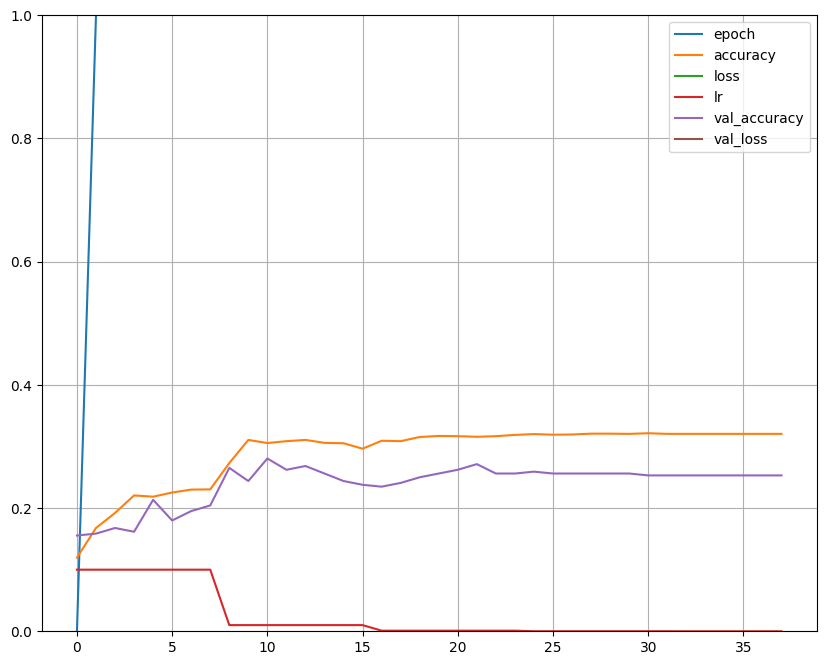

In [28]:
plot_losses_csv(history_classifier)

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
def get_predictions_from_dataset(classifier_model, dataset, true_labels):

    predictions = classifier_model.predict(dataset)

    # Calcola la matrice di confusione
    confusion_mat = confusion_matrix(true_labels, predictions.argmax(axis=1))

    # Calcola l'accuracy
    accuracy = accuracy_score(true_labels, predictions.argmax(axis=1))
    return predictions, true_labels, accuracy, confusion_mat

In [30]:
checkpoint = '/content/drive/MyDrive/Colab Notebooks/PROGETTO/Dense_classifier_training1.0/Dense_classifier_weights.38-2.26.hdf5'
classifier_model = keras.models.load_model(checkpoint)

In [ ]:
prediction, true_labels, accuracy, confusion_mat = get_predictions_from_dataset(classifier_model, ds_test, labels_test)

In [ ]:
result = prediction.argmax(axis=1)
print(result)

In [ ]:
print(true_labels)

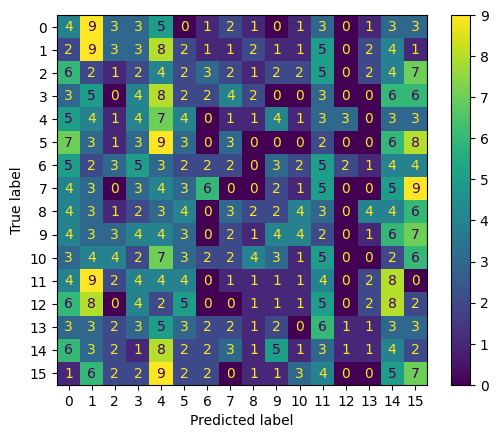

In [35]:
cm_display = ConfusionMatrixDisplay(confusion_mat).plot()

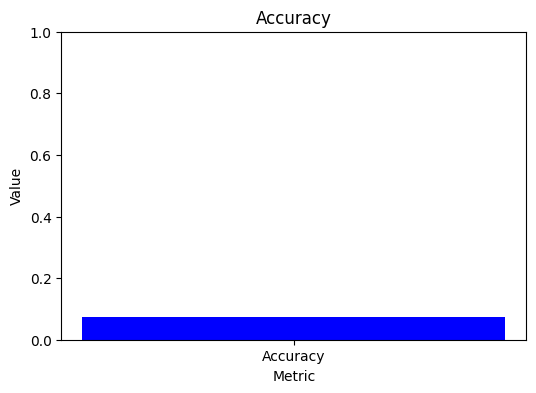

In [36]:
#ACCURACY
plt.figure(figsize=(6, 4))
plt.bar(['Accuracy'], [accuracy], color='blue')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Accuracy')
plt.ylim(0, 1.0)
plt.show()

In [ ]:
# print some example images with predictions
x, y = next(ds_validation)
pred = classifier_model.predict(x)
print(pred, '/n',pred[0])

mean = [103.939, 116.779, 123.68]
x_rgb = x[..., ::-1]   #  BGR -> RBG. Questa conversione è operata per motivi storici (in passato alcune reti erano allenate su immagini BGR)
x_rgb[..., 0] += mean[0]  # inverto l'operazione di "centratura" che sottrae la media
x_rgb[..., 1] += mean[1]
x_rgb[..., 2] += mean[2]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img=x_rgb[i,:,:,:]
    plt.imshow(img.astype(int))
    plt.xlabel(" {} : {} : {:1.2f}".format(y[i], np.argmax(pred[i]), pred[i].max()))
plt.show()